In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config('spark.driver.memory', '32g').getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 10:56:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/08 10:56:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [33]:
import numpy as np
import pandas as pd
import pyspark.sql.functions as F

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
boston_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
boston_pdf = pd.DataFrame(data, columns=boston_columns)
boston_pdf['PRICE'] = target
boston_sdf = spark.createDataFrame(boston_pdf)
boston_sdf.show()

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|PRICE|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0| 2.31| 0.0|0.538|6.575| 65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98| 24.0|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421| 78.9|4.9671|2.0|242.0|   17.8| 396.9| 9.14| 21.6|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185| 61.1|4.9671|2.0|242.0|   17.8|392.83| 4.03| 34.7|
|0.03237| 0.0| 2.18| 0.0|0.458|6.998| 45.8|6.0622|3.0|222.0|   18.7|394.63| 2.94| 33.4|
|0.06905| 0.0| 2.18| 0.0|0.458|7.147| 54.2|6.0622|3.0|222.0|   18.7| 396.9| 5.33| 36.2|
|0.02985| 0.0| 2.18| 0.0|0.458| 6.43| 58.7|6.0622|3.0|222.0|   18.7|394.12| 5.21| 28.7|
|0.08829|12.5| 7.87| 0.0|0.524|6.012| 66.6|5.5605|5.0|311.0|   15.2| 395.6|12.43| 22.9|
|0.14455|12.5| 7.87| 0.0|0.524|6.172| 96.1|5.9505|5.0|311.0|   15.2| 396.9|19.15| 27.1|
|0.21124|12.5| 7.87| 0.0|0.524|5

In [34]:
boston_sdf.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: double (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- PRICE: double (nullable = true)



In [35]:
boston_sdf.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|summary|              CRIM|                ZN|             INDUS|              CHAS|                NOX|                RM|               AGE|               DIS|              RAD|              TAX|           PTRATIO|                 B|            LSTAT|            PRICE|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  count|               506|               506|               506|               506|                506|               506|               506|               506|              506| 

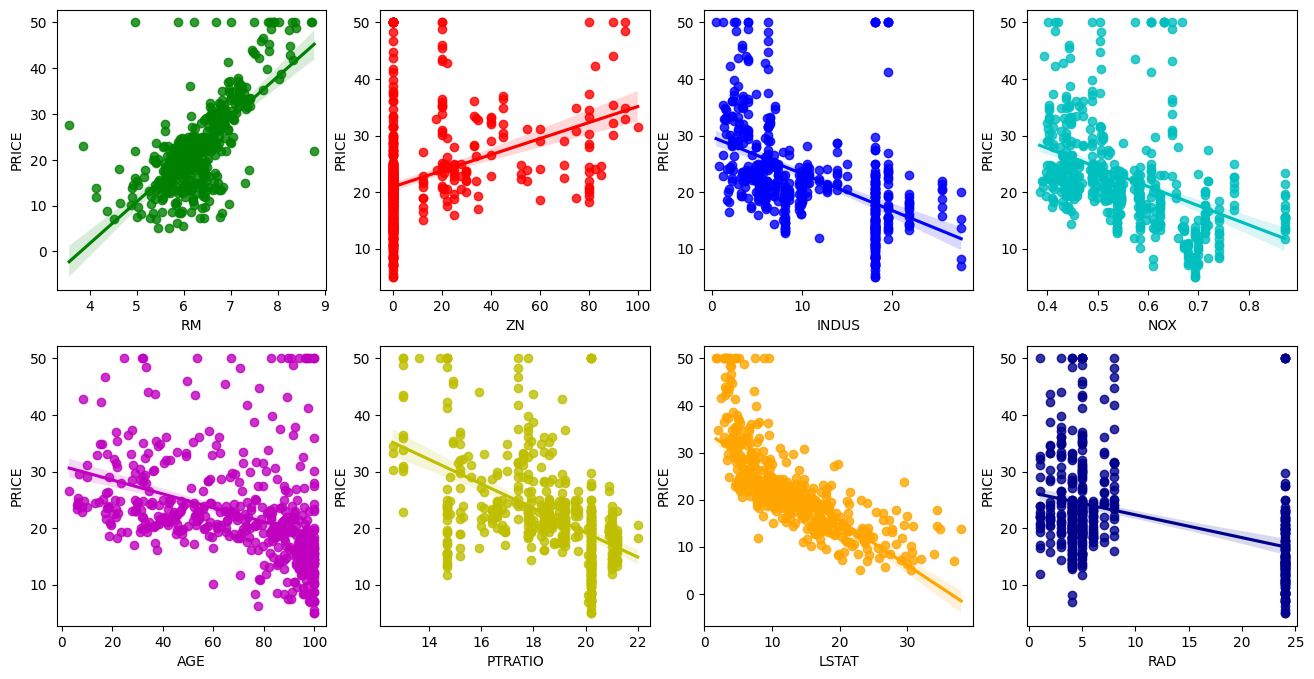

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
boston_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
colors = ['g', 'r', 'b', 'c', 'm', 'y', 'orange', 'darkblue' ]
for i, feature in enumerate(boston_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='PRICE', data=boston_pdf, ax=axs[row][col], color=colors[i])

In [52]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols=boston_columns, outputCol='features')
boston_sdf_vectorized = vector_assembler.transform(boston_sdf)
train_sdf, test_sdf = boston_sdf_vectorized.randomSplit([0.7, 0.3], seed=2021)
train_sdf.show()

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+--------------------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|PRICE|            features|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+--------------------+
|0.00632|18.0| 2.31| 0.0|0.538|6.575| 65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98| 24.0|[0.00632,18.0,2.3...|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185| 61.1|4.9671|2.0|242.0|   17.8|392.83| 4.03| 34.7|[0.02729,0.0,7.07...|
|0.03237| 0.0| 2.18| 0.0|0.458|6.998| 45.8|6.0622|3.0|222.0|   18.7|394.63| 2.94| 33.4|[0.03237,0.0,2.18...|
|0.09378|12.5| 7.87| 0.0|0.524|5.889| 39.0|5.4509|5.0|311.0|   15.2| 390.5|15.71| 21.7|[0.09378,12.5,7.8...|
|0.11747|12.5| 7.87| 0.0|0.524|6.009| 82.9|6.2267|5.0|311.0|   15.2| 396.9|13.27| 18.9|[0.11747,12.5,7.8...|
|0.17004|12.5| 7.87| 0.0|0.524|6.004| 85.9|6.5921|5.0|311.0|   15.2|386.71| 17.1| 18.9|[0.17004,12.5,7.8...|
|0.21124|12.5| 7.87

In [53]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='PRICE', maxIter=100, regParam=0)
lr_model = lr.fit(train_sdf)
lr_predictions = lr_model.transform(test_sdf)
lr_predictions.show()

23/06/08 11:23:10 WARN Instrumentation: [25c2fa5d] regParam is zero, which might cause numerical instability and overfitting.


+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+--------------------+------------------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|PRICE|            features|        prediction|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+--------------------+------------------+
|0.02731| 0.0| 7.07| 0.0|0.469|6.421| 78.9|4.9671|2.0|242.0|   17.8| 396.9| 9.14| 21.6|[0.02731,0.0,7.07...|24.721016364990348|
|0.02985| 0.0| 2.18| 0.0|0.458| 6.43| 58.7|6.0622|3.0|222.0|   18.7|394.12| 5.21| 28.7|[0.02985,0.0,2.18...| 24.84744600793138|
|0.06905| 0.0| 2.18| 0.0|0.458|7.147| 54.2|6.0622|3.0|222.0|   18.7| 396.9| 5.33| 36.2|[0.06905,0.0,2.18...|27.605359794231532|
|0.08829|12.5| 7.87| 0.0|0.524|6.012| 66.6|5.5605|5.0|311.0|   15.2| 395.6|12.43| 22.9|[0.08829,12.5,7.8...|22.541601157767726|
|0.14455|12.5| 7.87| 0.0|0.524|6.172| 96.1|5.9505|5.0|311.0|   15.2| 396.9|19.15| 27.1|[0.14455,12.5,7.8

In [56]:
def do_train_predict(lr_estimator, train_sdf, test_sdf):
    lr_model = lr_estimator.fit(train_sdf)
    lr_predictions = lr_model.transform(test_sdf)
    return lr_model, lr_predictions

In [57]:
lr_model, lr_predictions = do_train_predict(lr, train_sdf, test_sdf)

23/06/08 11:23:26 WARN Instrumentation: [61949294] regParam is zero, which might cause numerical instability and overfitting.


In [58]:
from pyspark.ml.evaluation import RegressionEvaluator

def get_reg_eval(predictions, label='PRICE'):
    mse_eval = RegressionEvaluator(labelCol=label, metricName='mse')
    rmse_eval = RegressionEvaluator(labelCol=label, metricName='rmse')
    r2_eval = RegressionEvaluator(labelCol=label, metricName='r2')
    print(f'mse: {mse_eval.evaluate(predictions)}, rmse_eval: {rmse_eval.evaluate(predictions)}, r2: {r2_eval.evaluate(predictions)}')

In [59]:
get_reg_eval(lr_predictions)

mse: 22.774213815010715, rmse_eval: 4.772233629550288, r2: 0.7322509234458953


In [60]:
for k, v in lr_model.extractParamMap().items():
    print(f'{k.name}: {v}')

aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: PRICE
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: True
tol: 1e-06


In [61]:
lr = LinearRegression(labelCol='PRICE', maxIter=100, regParam=0, standardization=False)
lr_model, lr_predictions = do_train_predict(lr, train_sdf, test_sdf)
get_reg_eval(lr_predictions)

23/06/08 11:23:29 WARN Instrumentation: [77a7e828] regParam is zero, which might cause numerical instability and overfitting.


mse: 22.77421381501082, rmse_eval: 4.772233629550299, r2: 0.732250923445894


In [62]:
lr_model.coefficients, lr_model.intercept

(DenseVector([-0.1079, 0.0502, 0.0752, 3.1405, -18.5264, 3.8893, -0.0057, -1.5024, 0.2742, -0.013, -0.9245, 0.0043, -0.5333]),
 38.0453261156097)

In [63]:
coeff = pd.Series(data=lr_model.coefficients, index=boston_columns)
coeff.sort_values(ascending=False)

RM          3.889262
CHAS        3.140497
RAD         0.274202
INDUS       0.075184
ZN          0.050203
B           0.004281
AGE        -0.005698
TAX        -0.012980
CRIM       -0.107928
LSTAT      -0.533317
PTRATIO    -0.924525
DIS        -1.502421
NOX       -18.526361
dtype: float64

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_coefficient(coefficients, columns):
    coeff = pd.Series(data=coefficients, index=columns).sort_values(ascending=False)
    sns.barplot(x=coeff.values, y=coeff.index)
    plt.show()

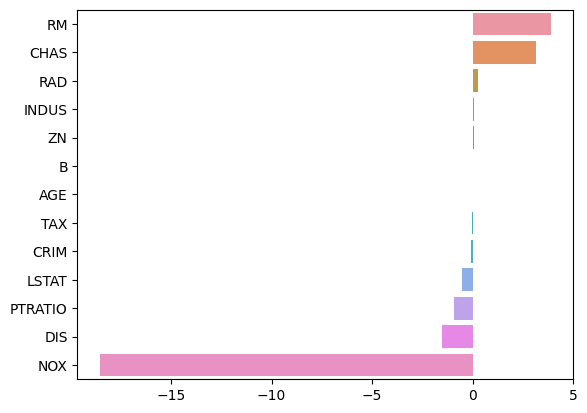

In [69]:
plot_coefficient(lr_model.coefficients, boston_columns)

mse: 23.03874291674024, rmse_eval: 4.799869052040925, r2: 0.7291409402304447


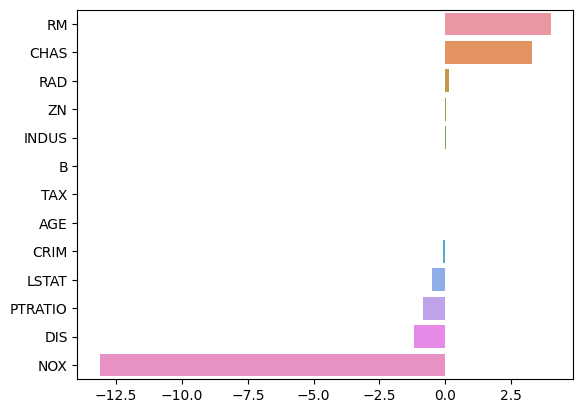

In [72]:
# mse: 22.774213815010715, rmse_eval: 4.772233629550288, r2: 0.7322509234458953
ridge = LinearRegression(labelCol='PRICE', maxIter=100, regParam=0.5, elasticNetParam=0)
ridge_model, ridge_predictions = do_train_predict(ridge, train_sdf, test_sdf)
get_reg_eval(ridge_predictions)
plot_coefficient(ridge_model.coefficients, boston_columns)

mse: 23.432179730750267, rmse_eval: 4.840679676527901, r2: 0.7245154306743632


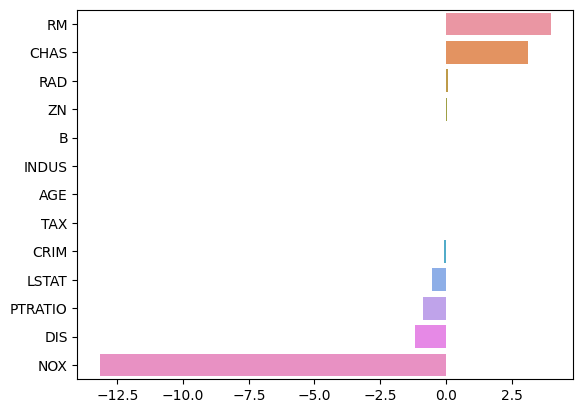

In [73]:
lasso = LinearRegression(labelCol='PRICE', maxIter=100, regParam=0.1, elasticNetParam=1)
lasso_model, lasso_predictions = do_train_predict(lasso, train_sdf, test_sdf)
get_reg_eval(lasso_predictions)
plot_coefficient(lasso_model.coefficients, boston_columns)

mse: 26.141443245561486, rmse_eval: 5.112870352899777, r2: 0.6926634945274253


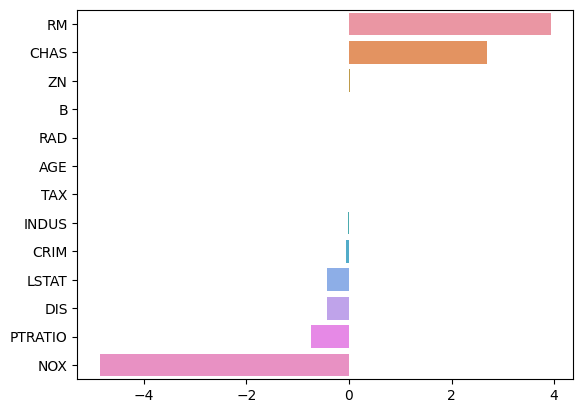

In [75]:
elastic_net = LinearRegression(labelCol='PRICE', maxIter=100, regParam=2, elasticNetParam=0.1)
elastic_net_model, elastic_net_predictions = do_train_predict(elastic_net, train_sdf, test_sdf)
get_reg_eval(elastic_net_predictions)
plot_coefficient(elastic_net_model.coefficients, boston_columns)

In [78]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

vector_assembler = VectorAssembler(inputCols=boston_columns, outputCol='features')
standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True)
boston_sdf_vectorized = vector_assembler.transform(boston_sdf)
boston_sdf_scaled = standard_scaler.fit(boston_sdf_vectorized).transform(boston_sdf_vectorized)
boston_sdf_scaled.show(truncate=False)

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+----------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CRIM   |ZN  |INDUS|CHAS|NOX  |RM   |AGE  |DIS   |RAD|TAX  |PTRATIO|B     |LSTAT|PRICE|features                                                                    |scaled_features                                                                                                                                                                                                                                                         |
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+-----------------------------------------------------

mse: 22.774186400706366, rmse_eval: 4.772230757277603, r2: 0.7322512457470176


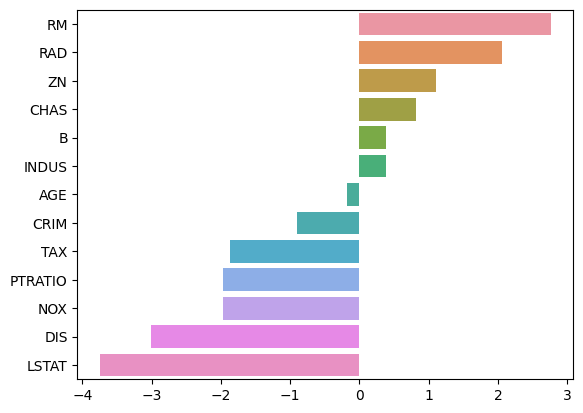

In [82]:
train_sdf_scaled, test_sdf_scaled = boston_sdf_scaled.randomSplit([0.7, 0.3], seed=2021)
ridge_scale = LinearRegression(featuresCol='scaled_features', labelCol='PRICE', regParam=0.1, elasticNetParam=0, standardization=False)
ridge_model, ridge_predictions = do_train_predict(ridge_scale, train_sdf_scaled, test_sdf_scaled)
get_reg_eval(ridge_predictions)
plot_coefficient(ridge_model.coefficients, boston_columns)

In [85]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='PRICE', 
                            maxDepth=5, numTrees=50)
rf_model, rf_predictions = do_train_predict(rf, train_sdf, test_sdf)
get_reg_eval(rf_predictions)

mse: 14.215668859517294, rmse_eval: 3.77036720486444, r2: 0.8328709723790346


LSTAT      0.393605
RM         0.274746
PTRATIO    0.071115
CRIM       0.061851
INDUS      0.043125
DIS        0.039812
TAX        0.030578
NOX        0.027302
AGE        0.027009
B          0.010606
CHAS       0.008060
RAD        0.006435
ZN         0.005756
dtype: float64


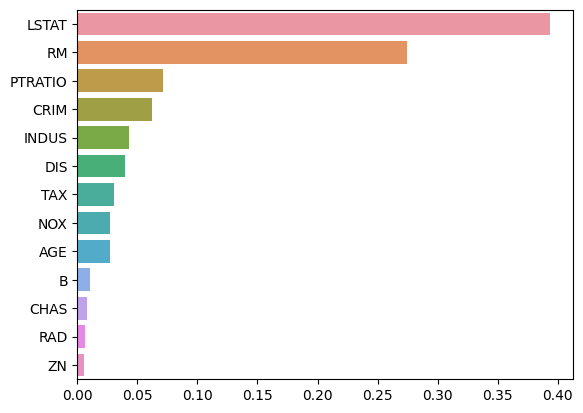

In [86]:
from pyspark.ml.linalg import DenseVector
import matplotlib.pyplot as plt
import seaborn as sns

rf_ft_importances = DenseVector(rf_model.featureImportances)
ft_importances = pd.Series(data=rf_ft_importances, index=boston_columns).sort_values(ascending=False)
print(ft_importances)
sns.barplot(x=ft_importances.values, y=ft_importances.index)
plt.show()